# member_class_registration (MCA): Raw Data Discovery & Insights

### Target Attributes: member_id, class_name, class_date, class_time

In [ ]:
import sqlite3
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

conn = sqlite3.connect(r"__PATH__")

df = pd.read_sql_query("SELECT * FROM member_class_registration", conn)

### Data Understanding, Cleaning & Preparation

In [3]:
df.shape

(1842, 12)

In [4]:
df.head(2)

,class_row_id,member_id,First Name,Last Name,Class Name,Instructor,Class Date,Class Time,Location,Class Registration Date,Status,Notes
0,1,ABC1239,Thomas,Pena,Strength Training,Mike Brown,2025-07-07,07:20 PM,Gym Floor,2024-08-02,Registered,FIRST TIME ATTENDING
1,2,ABC1440,Michael,Holland,nan,Carlos Ruiz,2025-07-25,04:49 PM,Studio B,2025-07-22,Registered,BRINGING OWN MAT


In [5]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")

In [6]:
df.columns

Index(['class_row_id', 'member_id', 'first_name', 'last_name', 'class_name',
       'instructor', 'class_date', 'class_time', 'location',
       'class_registration_date', 'status', 'notes'],
      dtype='object')

In [7]:
df = df[[#'class_row_id', 
          'member_id',
          #'Last_Name', 
          'class_name', 
          #'Instructor',
       'class_date', 'class_time'
       #'Location',
       #'Class_Registration_Date', 'Status', 'Notes'
       ]].copy()

In [8]:
df.columns, df.dtypes

(Index(['member_id', 'class_name', 'class_date', 'class_time'], dtype='object'),
 member_id     object
 class_name    object
 class_date    object
 class_time    object
 dtype: object)

In [9]:
df['class_time'] = pd.to_datetime(df['class_time'], format="%I:%M %p").dt.time
df['class_date'] = pd.to_datetime(df['class_date'], format='%Y-%m-%d', errors='coerce')

In [10]:
df.isna().sum()

member_id       0
class_name    139
class_date      0
class_time      0
dtype: int64

In [11]:
df['class_name'].unique()

array(['Strength Training ', 'nan ', None, 'Strength Training',
       'Zumba Dance ', 'Yoga Basics', 'Spin Class', 'ZUMBA DANCE',
       'Zumba Dance', 'SPIN CLASS', 'YOGA BASICS', 'Spin Class ',
       'Yoga Basics ', 'STRENGTH TRAINING', 'NAN', 'ZUMBA DANCE ',
       'SPIN CLASS '], dtype=object)

In [12]:
df['class_name'] = df['class_name'].str.strip().str.lower()
df['class_name'].unique()

array(['strength training', 'nan', None, 'zumba dance', 'yoga basics',
       'spin class'], dtype=object)

In [13]:
df['class_name'] = df['class_name'].replace([None, 'nan'], np.nan)
df['class_name'].unique()

array(['strength training', nan, 'zumba dance', 'yoga basics',
       'spin class'], dtype=object)

In [14]:
df['class_name'].value_counts(dropna=False)

class_name
zumba dance          431
spin class           428
yoga basics          416
strength training    413
NaN                  154
Name: count, dtype: int64

In [15]:
df['class_name'] = df['class_name'].fillna("general class")

In [16]:
df['class_name'].value_counts(dropna=False)

class_name
zumba dance          431
spin class           428
yoga basics          416
strength training    413
general class        154
Name: count, dtype: int64

In [17]:
df.head()

,member_id,class_name,class_date,class_time
0,ABC1239,strength training,2025-07-07,19:20:00
1,ABC1440,general class,2025-07-25,16:49:00
2,ABC1868,general class,2025-07-25,19:11:00
3,ABC1389,strength training,2025-01-14,06:44:00
4,ABC1797,strength training,2025-04-11,15:26:00


In [18]:
df[df['member_id'] == "ABC1010"]

,member_id,class_name,class_date,class_time
422,ABC1010,zumba dance,2025-04-04,17:18:00
1534,ABC1010,yoga basics,2025-07-01,16:46:00


### Member Level Aggregates

In [19]:
df["total_classes"] = df.groupby("member_id")["class_name"].transform("count")

df[df['member_id'] == "ABC1010"]

,member_id,class_name,class_date,class_time,total_classes
422,ABC1010,zumba dance,2025-04-04,17:18:00,2
1534,ABC1010,yoga basics,2025-07-01,16:46:00,2


In [20]:
member_fav_class = (
    df.groupby(['member_id', 'class_name'])
      .size()
      .reset_index(name='count')
)

# Pick class with max count per member
member_fav_class = member_fav_class.loc[
    member_fav_class.groupby('member_id')['count'].idxmax()
]

member_fav_class = member_fav_class[['member_id', 'class_name']].rename(
    columns={'class_name': 'favorite_class'}
)

df = df.merge(member_fav_class, on="member_id", how="left")

df[df['member_id'] == "ABC1010"]

,member_id,class_name,class_date,class_time,total_classes,favorite_class
422,ABC1010,zumba dance,2025-04-04,17:18:00,2,yoga basics
1534,ABC1010,yoga basics,2025-07-01,16:46:00,2,yoga basics


In [21]:
# extract features
df['day_of_week'] = df['class_date'].dt.day_name()
df['hour'] = df['class_time'].apply(lambda t: t.hour)

# favorite day
fav_day = (
    df.groupby('member_id')['day_of_week']
      .agg(lambda x: x.mode()[0])
      .reset_index(name='favorite_day')
)

# favorite hour
fav_hour = (
    df.groupby('member_id')['hour']
      .agg(lambda x: x.mode()[0])
      .reset_index(name='favorite_hour')
)

# merge back
df = df.merge(fav_day, on='member_id', how='left')
df = df.merge(fav_hour, on='member_id', how='left')

df[df['member_id'] == "ABC1010"]

,member_id,class_name,class_date,class_time,total_classes,favorite_class,day_of_week,hour,favorite_day,favorite_hour
422,ABC1010,zumba dance,2025-04-04,17:18:00,2,yoga basics,Friday,17,Friday,16
1534,ABC1010,yoga basics,2025-07-01,16:46:00,2,yoga basics,Tuesday,16,Friday,16


In [22]:
# last class date per member
last_class = (
    df.groupby('member_id')['class_date']
      .max()
      .reset_index(name='latest_class')
)

df = df.merge(last_class, on='member_id', how='left') 
df[df['member_id'] == "ABC1010"]

,member_id,class_name,class_date,class_time,total_classes,favorite_class,day_of_week,hour,favorite_day,favorite_hour,latest_class
422,ABC1010,zumba dance,2025-04-04,17:18:00,2,yoga basics,Friday,17,Friday,16,2025-07-01
1534,ABC1010,yoga basics,2025-07-01,16:46:00,2,yoga basics,Tuesday,16,Friday,16,2025-07-01


In [23]:
# now build the member-level table
member_features = (
    df[['member_id','total_classes','favorite_class','favorite_day','favorite_hour']]
    .drop_duplicates('member_id')
)    

member_features[member_features['member_id'] == "ABC1010"]

,member_id,total_classes,favorite_class,favorite_day,favorite_hour
422,ABC1010,2,yoga basics,Friday,16


In [24]:
member_features.head(6)

,member_id,total_classes,favorite_class,favorite_day,favorite_hour
0,ABC1239,3,spin class,Monday,15
1,ABC1440,3,general class,Wednesday,7
2,ABC1868,1,general class,Friday,19
3,ABC1389,3,spin class,Thursday,6
4,ABC1797,2,strength training,Friday,6
5,ABC1468,3,general class,Monday,5


### Load to clean_db

In [ ]:
con_out = sqlite3.connect(r"__PATH__")
member_features.to_sql("member_class_features", con_out, if_exists="replace", index=False)
con_out.close()

## Exploration

In [26]:
# Order the days
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Count how many members have each favorite_day
dow_counts = (
    member_features['favorite_day']
    .value_counts()
    .reindex(dow_order, fill_value=0)
)

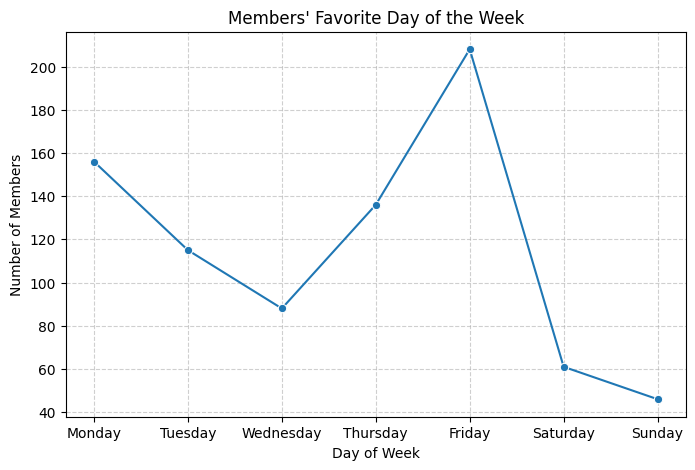

In [27]:
plt.figure(figsize=(8,5))
sns.lineplot(x=dow_counts.index, y=dow_counts.values, marker="o")
plt.title("Members' Favorite Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Members")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [28]:
class_counts = member_features['favorite_class'].value_counts()
class_counts

favorite_class
spin class           247
strength training    191
yoga basics          132
zumba dance          131
general class        109
Name: count, dtype: int64

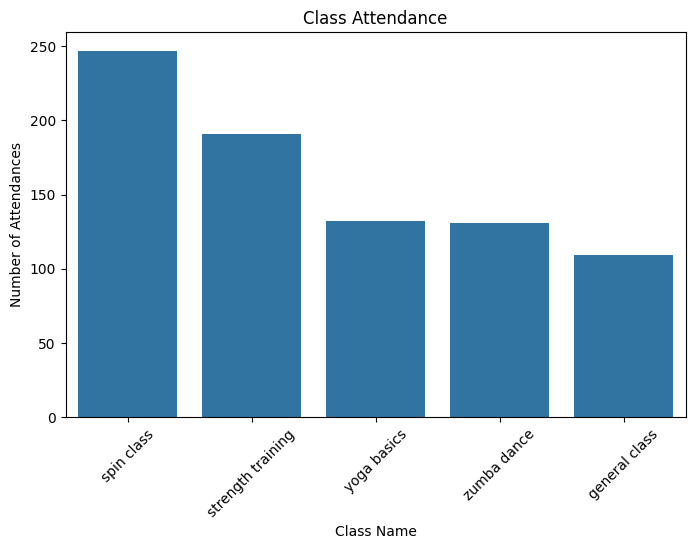

In [29]:
plt.figure(figsize=(8,5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Attendance")
plt.xlabel("Class Name")
plt.ylabel("Number of Attendances")
plt.xticks(rotation=45)
plt.show()

In [30]:
# ordered days
days_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow_dtype = pd.CategoricalDtype(days_order, ordered=True)

# make sure favorite_day is ordered categorical
member_features['favorite_day'] = member_features['favorite_day'].astype(dow_dtype)

# pivot: rows = day, cols = hour, values = # of members
heatmap_pivot = (
    member_features.groupby(['favorite_day','favorite_hour'], observed=True)
      .size()
      .unstack(fill_value=0)
      .reindex(days_order)        # keep rows in weekday order
      .sort_index(axis=1)         # keep hours in order
)

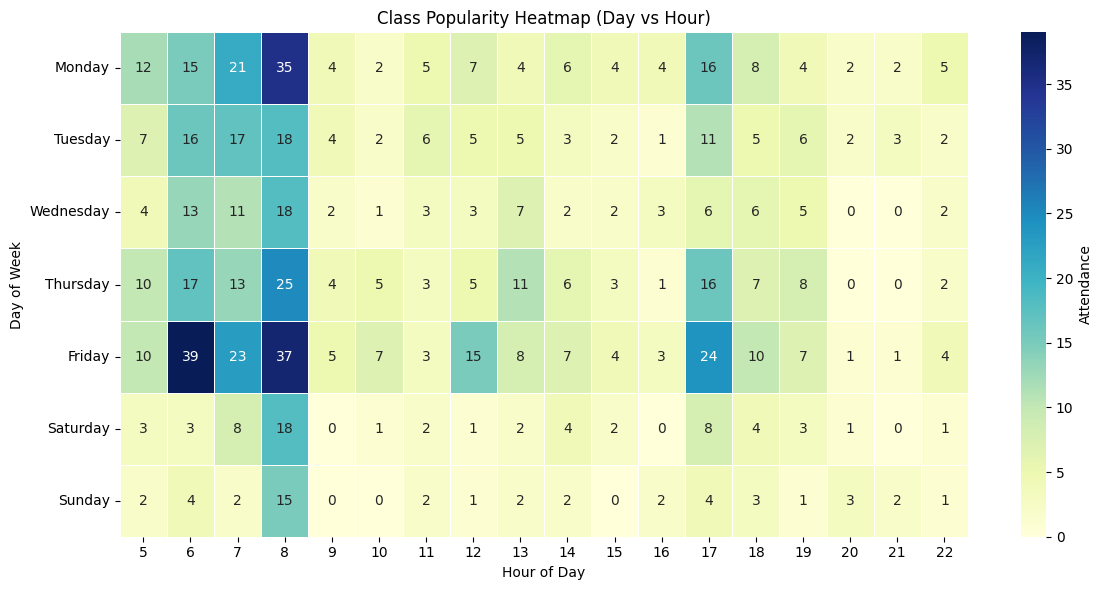

In [31]:
# 4) Plot
plt.figure(figsize=(12,6))
sns.heatmap(
    heatmap_pivot, annot=True, fmt=".0f",
    cmap="YlGnBu", linewidths=.5, cbar_kws={"label": "Attendance"}
)
plt.title("Class Popularity Heatmap (Day vs Hour)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()